In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

clean_df = pd.read_csv("../data/processed/cleaned_data.csv", sep=";")

sns.set_palette("rocket")

In [7]:
with pd.option_context("display.float_format", "{:.1f}".format):
    print(
        clean_df["price_pln"].describe(
            percentiles=[0.1, 0.25, 0.5, 0.75, 0.8, 0.9, 0.95]
        )
    )

price_ranges = [
    0,
    3_000,
    5_000,
    10_000,
    20_000,
    50_000,
    80_000,
    100_000,
    150_000,
    200_000,
    300_000,
    400_000,
    500_000,
    600_000,
    700_000,
    800_000,
    4_000_000,
]
df = clean_df.drop(
    [
        "url",
        "color",
        "posted_date",
        "price_net_info",
        "location",
        "price",
        "country_of_origin",
    ],
    axis=1,
    errors="ignore",
)

df["capacity"] = (
    df["capacity"]
    .str.replace(" cm3", "", regex=False)
    .str.replace(" ", "")
    .astype(float)
)

df["power"] = (
    df["power"].str.replace(" ", "").str.replace("KM", "", regex=False).astype(float)
)

df["mileage"] = (
    df["mileage"].str.replace(" km", "", regex=False).str.replace(" ", "").astype(float)
)

df["price_pln"] = (
    df["price_pln"].str.replace(" ", "").str.replace(",", ".").astype(float)
)

df = df.dropna(
    subset=[
        "model",
        "condition",
        "fuel",
        "brand",
        "body_type",
        "accident_free",
        "year",
        "capacity",
        "power",
        "mileage",
        "seats",
        "description",
    ]
)

count      23752
unique      4900
top       39 900
freq         293
Name: price_pln, dtype: object


In [10]:
df["price_pln"].describe()

count    1.576200e+04
mean     1.048767e+05
std      1.011148e+05
min      1.228770e+03
25%      4.290000e+04
50%      7.480000e+04
75%      1.439100e+05
max      2.560000e+06
Name: price_pln, dtype: float64

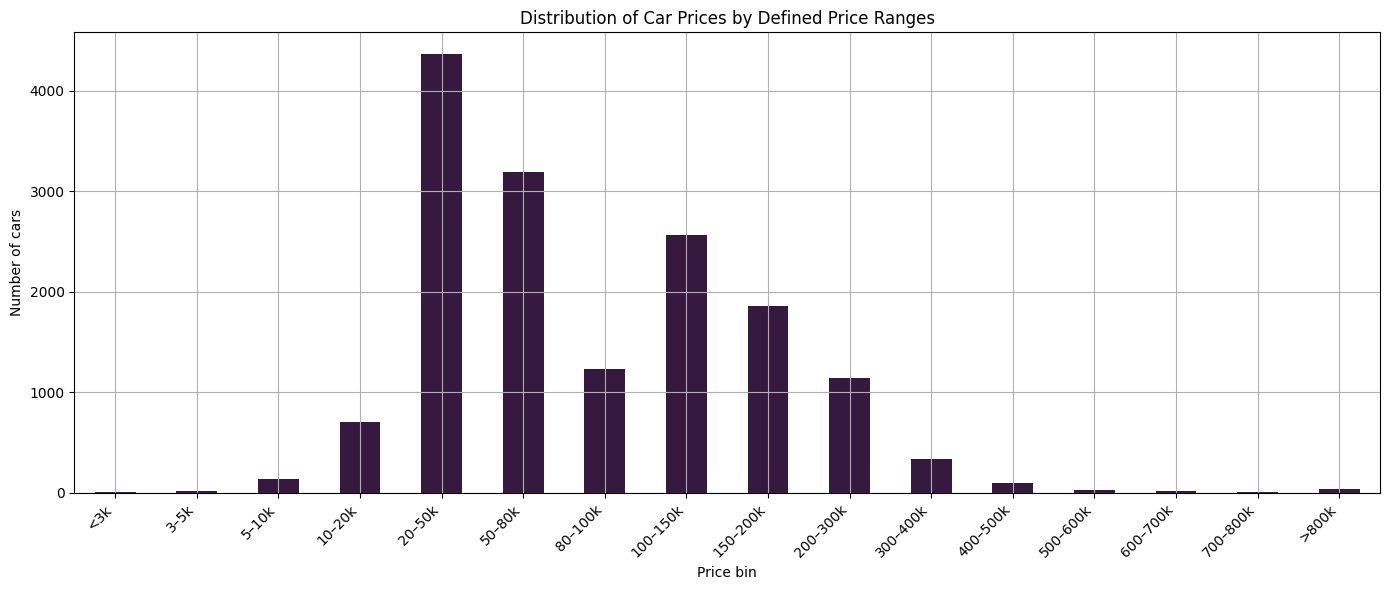

In [18]:
prices = df["price_pln"].values
price_labels = [
    "<3k", "3–5k", "5–10k", "10–20k", "20–50k", "50–80k",
    "80–100k", "100–150k", "150–200k", "200–300k", "300–400k",
    "400–500k", "500–600k", "600–700k", "700–800k", ">800k",
]

ranges = pd.cut(prices, bins=price_ranges, labels=price_labels)

plt.figure(figsize=(14,6))
ranges.value_counts().loc[price_labels].plot(kind="bar")

plt.grid()
plt.xticks(rotation=45, ha="right")
plt.ylabel("Number of cars")
plt.xlabel("Price bin")
plt.title("Distribution of Car Prices by Defined Price Ranges")
plt.tight_layout()
plt.show()

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import TargetEncoder
from stop_words import get_stop_words


pl_stopwords = get_stop_words("pl")


X = df.drop(["price_pln"], axis=1, errors="ignore")
y = pd.cut(df["price_pln"], bins=price_ranges, labels=False)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

cat_feats = ["model", "condition", "fuel", "brand", "body_type", "accident_free"]
# cat_feats = ["model", "brand", "accident_free"]
num_feats = ["year", "capacity", "power", "mileage", "seats"]
# num_feats = ["year", "capacity", "power", "mileage"]

In [ ]:
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

text_col = "description"

rfecv_preprocess = ColumnTransformer(
    [
        ("num", "passthrough", num_feats),
        ("cat", TargetEncoder(), cat_feats),
    ],
    remainder="drop",
)

rfecv_model = Pipeline(
    [
        ("prep", rfecv_preprocess),
        (
            "rfecv",
            RFECV(
                estimator=RandomForestClassifier(n_estimators=250, n_jobs=-1),
                cv=3,
                step=1,
                # verbose=1,
                scoring="accuracy",
                n_jobs=-1,
            ),
        ),
    ]
)


rfecv_model.fit(X_train, y_train)

mask = rfecv_model.named_steps["rfecv"].support_

selected_num_cols = [
    col for col, keep in zip(num_feats + cat_feats, mask) if keep and col in num_feats
]
selected_cat_cols = [
    col for col, keep in zip(num_feats + cat_feats, mask) if keep and col in cat_feats
]

print("Kept numeric:", selected_num_cols)
print("Kept categorical:", selected_cat_cols)

/Users/tomekogiolda/Projects/agh/.conda/lib/python3.11/site-packages/sklearn/model_selection/_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/Users/tomekogiolda/Projects/agh/.conda/lib/python3.11/site-packages/sklearn/model_selection/_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


Fitting estimator with 52 features.
Fitting estimator with 52 features.
Fitting estimator with 52 features.
Fitting estimator with 51 features.
Fitting estimator with 51 features.
Fitting estimator with 51 features.
Fitting estimator with 50 features.
Fitting estimator with 50 features.
Fitting estimator with 50 features.
Fitting estimator with 49 features.
Fitting estimator with 49 features.
Fitting estimator with 49 features.
Fitting estimator with 48 features.
Fitting estimator with 48 features.
Fitting estimator with 48 features.
Fitting estimator with 47 features.
Fitting estimator with 47 features.
Fitting estimator with 47 features.
Fitting estimator with 46 features.
Fitting estimator with 46 features.
Fitting estimator with 46 features.
Fitting estimator with 45 features.
Fitting estimator with 45 features.
Fitting estimator with 45 features.
Fitting estimator with 44 features.
Fitting estimator with 44 features.
Fitting estimator with 44 features.
Fitting estimator with 43 fe

,steps,"[('prep', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


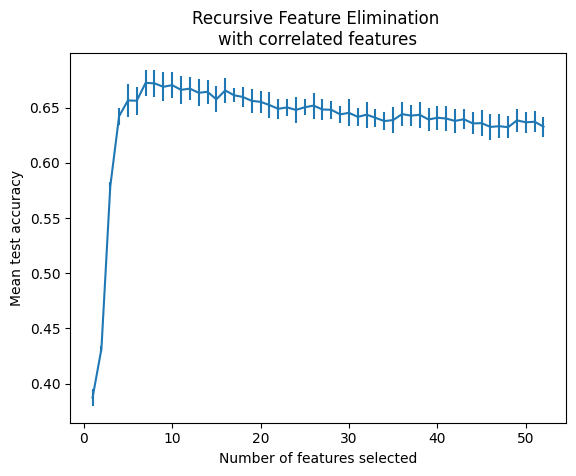

In [ ]:
data = {
    key: value
    for key, value in rfecv_model.named_steps['rfecv'].cv_results_.items()
    if key in ["n_features", "mean_test_score", "std_test_score"]
}
cv_results = pd.DataFrame(data)

plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Mean test accuracy")
plt.errorbar(
    x=cv_results["n_features"],
    y=cv_results["mean_test_score"],
    yerr=cv_results["std_test_score"],
)
plt.title("Recursive Feature Elimination \nwith correlated features")
plt.show()

## RFECV without description field

accuracy: 0.6824835941443715

report:
               precision    recall  f1-score   support

           2       0.60      0.50      0.55         6
           3       0.69      0.40      0.51        62
           4       0.72      0.75      0.73       361
           5       0.63      0.74      0.68       346
           6       0.60      0.44      0.51       171
           7       0.72      0.75      0.73       410
           8       0.70      0.70      0.70       335
           9       0.68      0.72      0.70       193
          10       0.63      0.49      0.55        59
          11       0.88      0.61      0.72        23
          12       0.17      0.50      0.25         2
          13       0.00      0.00      0.00         5
          14       0.00      0.00      0.00         2
          15       0.40      0.33      0.36         6

    accuracy                           0.68      1981
   macro avg       0.53      0.49      0.50      1981
weighted avg       0.68      0.68      0.

/Users/tomekogiolda/Projects/agh/.conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/tomekogiolda/Projects/agh/.conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/tomekogiolda/Projects/agh/.conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifi

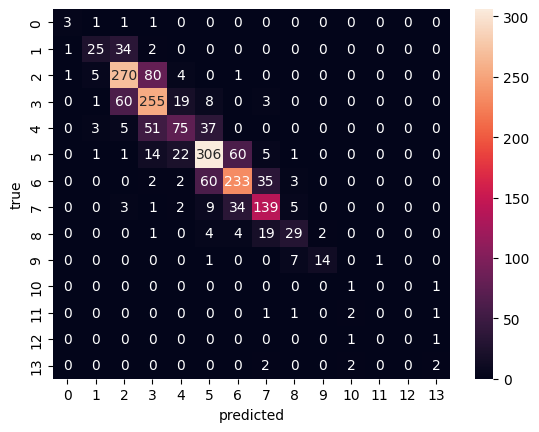

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


y_pred = rfecv_model.predict(X_test)

print("accuracy:", accuracy_score(y_test, y_pred))
print("\nreport:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d")
plt.xlabel("predicted")
plt.ylabel("true")
plt.show()

## RFECV + TFIDF Description

In [334]:
preprocess_tfidf = ColumnTransformer(
    [
        ("num", "passthrough", selected_num_cols),
        ("cat", TargetEncoder(), selected_cat_cols),
        ("text", TfidfVectorizer(max_features=5000, stop_words=pl_stopwords), text_col),
    ],
    remainder="drop",
)

model = Pipeline(
    [
        ("prep", preprocess_tfidf),
        ("clf", RandomForestClassifier(n_estimators=250, n_jobs=-1)),
    ]
)

model.fit(X_train, y_train)

/Users/tomekogiolda/Projects/agh/.conda/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['jeå', 'jä', 'li'] not in stop_words.
  warnings.warn(


,steps,"[('prep', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


accuracy: 0.712266532054518

report:
               precision    recall  f1-score   support

           2       1.00      0.33      0.50         6
           3       0.93      0.21      0.34        62
           4       0.69      0.84      0.76       361
           5       0.64      0.76      0.70       346
           6       0.78      0.40      0.53       171
           7       0.74      0.77      0.75       410
           8       0.70      0.73      0.72       335
           9       0.80      0.73      0.76       193
          10       0.78      0.73      0.75        59
          11       1.00      0.35      0.52        23
          12       0.50      1.00      0.67         2
          13       1.00      0.40      0.57         5
          14       1.00      0.50      0.67         2
          15       1.00      0.50      0.67         6

    accuracy                           0.71      1981
   macro avg       0.83      0.59      0.64      1981
weighted avg       0.73      0.71      0.7

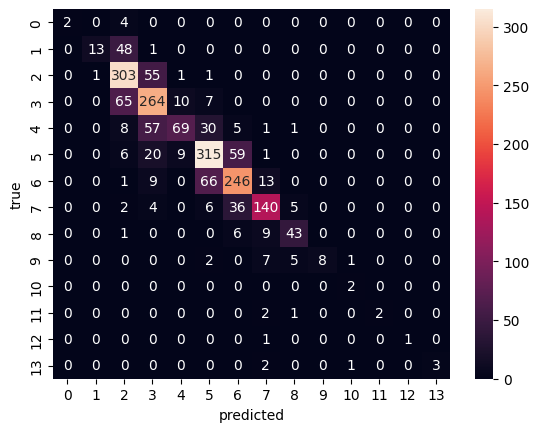

In [335]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


y_pred = model.predict(X_test)

print("accuracy:", accuracy_score(y_test, y_pred))
print("\nreport:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d")
plt.xlabel("predicted")
plt.ylabel("true")
plt.show()